In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [36]:
#df_TY_features = pd.read_parquet(file_name_TY_features1)
df_TY_users = pd.read_parquet("/Users/wendyessilfie/Documents/GitHub/Business-statistics-/TaoYin_User_Transactions.parquet")

1. FEATURE ENGINEERING of CUSTOMERS by PROFIT

In [37]:
# Calculate the 'profit' column using the formula (sum2 - sum1)
df_TY_users.loc[:,"profit"] = (df_TY_users["sum2"] - df_TY_users["sum1"])
df_TY_users.head()

,customer,invoice,invoice_date,artikelnr,volume,sum1,sum2,postcode_delivery,postcode_customer,channel,profit
0,2284,1187467,2020-01-02,6439980,24,343.73,362.30,80413,80413,Tel 86041,18.57
1,2284,1187467,2020-01-02,6439981,60,1067.64,1119.96,80413,80413,Tel 86041,52.32
2,2284,1187467,2020-01-02,6420905,120,2214.00,2408.40,80413,80413,Tel 86041,194.40
3,1704,1191447,2020-01-17,8433401,1,21.52,19.32,81724,81724,OTC 81812,-2.20
4,45,1187691,2020-01-03,7180136,4,28.91,28.49,81796,81796,Web Order,-0.42


In [38]:
df_TY_customer_merged = df_TY_users.groupby("customer").agg({'profit' : ['sum'], 'sum2' : ['sum']}).reset_index()
df_TY_customer_merged.head(10)

# Flatten the column index
df_TY_customer_merged.columns = ['_'.join(col).strip() for col in df_TY_customer_merged.columns.values]

# Rename sales column
df_TY_customer_merged = df_TY_customer_merged.rename(columns={'sum2_sum': 'sales_sum'})

# Display the DataFrame
print(df_TY_customer_merged.head(10))

   customer_  profit_sum   sales_sum
0          0       -2.53       13.72
1          3    10263.09   712214.87
2          4     -736.60     3135.02
3          5    -2220.25     2199.45
4          6       -8.89       99.48
5         14    33219.18  1397887.79
6         17    -1381.80      205.80
7         21       35.63      294.17
8         22     -126.29     1048.19
9         30       -8.49      289.87


In [39]:
column_sum1 = df_TY_customer_merged['profit_sum'].sum()
column_sum2 = df_TY_customer_merged['sales_sum'].sum()
print("Sum of Profit:", int(column_sum1))
print("Sum of Sales:", int(column_sum2))

Sum of Profit: 13312202
Sum of Sales: 127824304


Intermediate conclusion 1.1: The company is profitable with a margin of ~10%

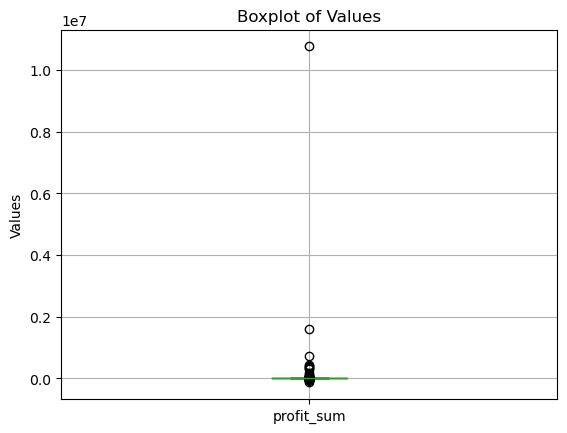

In [40]:
df_TY_customer_merged.boxplot(column='profit_sum')

# Labeling the axes
plt.title('Boxplot of Values')
plt.ylabel('Values')

# Show the plot
plt.show()

Intermediate conclusion 1.2: There are outliers which will distort my analysis. I need to take care of these outliers. 

In [41]:
# Extract the outliers

median = df_TY_customer_merged['profit_sum'].median()
mad = (df_TY_customer_merged['profit_sum'] - median).abs().median()

# Calculate modified Z-scores
df_TY_customer_merged['Modified Z-Score'] = 0.6745 * (df_TY_customer_merged['profit_sum'] - median) / mad

# Identify outliers
outliers = df_TY_customer_merged[df_TY_customer_merged['Modified Z-Score'].abs() > 3.5]

outlier_customers = outliers['customer_'].tolist()
#print(outlier_customers)
print("Outliers using Z-score:")
print(outliers)

Outliers using Z-score:
      customer_  profit_sum   sales_sum  Modified Z-Score
1             3    10263.09   712214.87         23.966517
3             5    -2220.25     2199.45         -4.621446
5            14    33219.18  1397887.79         76.538013
12           40    -2287.33    19653.09         -4.775065
14           42    -2465.45   104423.75         -5.182976
...         ...         ...         ...               ...
1060       2478    23093.03   149798.85         53.348226
1062       2486     6255.48    33897.85         14.788733
1064       2488     5513.15   224654.12         13.088731
1066       2492    -3160.73    15763.15         -6.775229
1069       2500   -13025.00    50832.34        -29.365288

[291 rows x 4 columns]


In [42]:
# Check if there are any infinite values in the margins_sum column
print(df_TY_customer_merged['profit_sum'].isin([np.inf, -np.inf]).sum())

# Replace infinite values with NaN
df_TY_customer_merged['profit_sum'].replace([np.inf, -np.inf], np.nan, inplace=True)

# Optionally, fill NaN values with the maximum of the non-infinite data
df_TY_customer_merged['profit_sum'].fillna(df_TY_customer_merged['profit_sum'].max(), inplace=True)


0


/var/folders/fh/wbkbplv94qz11z3b8wk1mrmw0000gn/T/ipykernel_46943/180137320.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_TY_customer_merged['profit_sum'].replace([np.inf, -np.inf], np.nan, inplace=True)
/var/folders/fh/wbkbplv94qz11z3b8wk1mrmw0000gn/T/ipykernel_46943/180137320.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object o

In [43]:
# Determine the min and max values of 'profit_sum' to create bins without the outliers
filtered_df = df_TY_customer_merged[~df_TY_customer_merged['customer_'].isin(outlier_customers)]
min_profit = filtered_df['profit_sum'].min()
max_profit = filtered_df['profit_sum'].max()

# Create evenly spaced bins for margins using min and max values
bins = np.linspace(min_profit, max_profit, num=6)  # Creates 5 equal-width intervals
labels = ['Very Low', 'Low', 'Medium', 'High', 'Very High']

# Create profit categories based on these equal-width bins
df_TY_customer_merged['profit_category'] = pd.cut(df_TY_customer_merged['profit_sum'], bins=bins, labels=labels, include_lowest=True)
df_TY_customer_merged.loc[df_TY_customer_merged['profit_sum'] > max_profit, 'profit_category'] = 'Very High' # bring the outliers back
df_TY_customer_merged.loc[df_TY_customer_merged['profit_sum'] < min_profit, 'profit_category'] = 'Very Low'  # bring the outliers back

# Sort by margin category and volume
sorted_df = df_TY_customer_merged.sort_values(by=['profit_category', 'sales_sum'], ascending=[True, False]).reset_index()

# Display the sorted dataframe
#print(sorted_df[['customer_', 'profit_sum', 'sales_sum', 'profit_category']].head(20))
sorted_df['profit_category'].value_counts()


profit_category
Medium       526
Very Low     286
Low          113
Very High     76
High          69
Name: count, dtype: int64

In [46]:
# Create evenly spaced bins for margins
bins = 5  # This creates 5 equal-width intervals
labels = ['Very Low', 'Low', 'Medium', 'High', 'Very High']

# Create margin categories based on equal-width bins
df_TY_customer_merged['margin_category'] = pd.cut(df_TY_customer_merged['profit_sum'], bins=bins, labels=labels)

# Sort by margin category and volume
sorted_df = df_TY_customer_merged.sort_values(by=['margin_category', 'volume_sum'], ascending=[True, False])

# Display the sorted dataframe
sorted_df[['customer_', 'profit_sum', 'volume_sum', 'margin_category']].head(20)


KeyError: 'volume_sum'

In [ ]:
df_TY_customer_merged["margin_category"].value_counts()['Very High']

KeyError: 'margin_category'

In [ ]:
# Plot the number of customers in each margin category
df_TY_customer_merged['margin_category'].value_counts().sort_index().plot(kind='bar')

# Add labels and title
plt.xlabel('Margin Category')
plt.ylabel('Number of Customers')
plt.title('Number of Customers by Margin Category')

# Show the plot
plt.show()

KeyError: 'margin_category'

In [ ]:
df_TY_customer_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1070 entries, 0 to 1069
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   customer_         1070 non-null   int64   
 1   profit_sum        1070 non-null   float64 
 2   sales_sum         1070 non-null   float64 
 3   Modified Z-Score  1070 non-null   float64 
 4   profit_category   1070 non-null   category
dtypes: category(1), float64(3), int64(1)
memory usage: 34.8 KB


In [ ]:
# ----- vanessa -----
# Get unique values from 'postcode_customer' column
# customer_postcode_set = df_TY_users['postcode_customer'].unique()

# Convert the list of unique values to a set
# customer_set = set(customer_postcode_set)

# Print count of unique values
# print("Count: ", len(customer_set))

count_customer_postcode = df_TY_users['postcode_customer'].nunique()
print(count_customer_postcode)

593


In [ ]:
# Get unique values from 'postcode_delivery' column
# delivery_postcode_set = df_TY_users['postcode_delivery'].unique()

# Convert the list of unique values to a set
# delivery_set = set(delivery_postcode_set)

# Print count of unique values
# print("Count: ", len(delivery_set))

count_delivery_postcode = df_TY_users['postcode_delivery'].nunique()
print(count_delivery_postcode)

659


In [ ]:
# difference between no of unique delivery postcodes and the customer postcodes
dropshippers_count = count_delivery_postcode - count_customer_postcode

print(dropshippers_count)

66


In [ ]:
# ----- wendy -----
mismatched_postcode = df_TY_users[df_TY_users["postcode_delivery"] != df_TY_users["postcode_customer"]]
print(f"Number of mismatched rows: {mismatched_postcode.shape[0]}")

# Step 3: Optionally, you can display a sample of mismatched rows to verify
print(mismatched_postcode.head(10))


Number of mismatched rows: 71089
    customer  invoice invoice_date  artikelnr  volume    sum1    sum2  \
19      1236  1187648   2020-01-03    3025558     100   22.70   28.78   
20      1236  1187648   2020-01-03    6205512     400   12.58   14.00   
75       595  1189396   2020-01-10    8591166       1  179.91  194.23   
76       595  1189396   2020-01-10    8591372       1   26.14   26.66   
77       595  1189396   2020-01-10    8590531       2   57.25   59.00   
78       595  1189396   2020-01-10    8591737       2   81.64   71.67   
79       595  1189396   2020-01-10    8590572       2   23.90   23.79   
80       595  1189396   2020-01-10    8590630      15   13.10   14.65   
81       595  1189396   2020-01-10    8590721      15   14.95   14.65   
82       595  1189396   2020-01-10    8590788      10    9.97    9.77   

    postcode_delivery  postcode_customer    channel  profit  
19              81620              81689  ERP Order    6.08  
20              81620              8168

In [ ]:
# Create a new column 'mismatch' using a vectorized comparison
df_TY_users['mismatch'] = df_TY_users["postcode_delivery"] != df_TY_users["postcode_customer"]
df_TY_users['mismatch'] = df_TY_users['mismatch'].replace({True: 'Yes', False: 'No'})

# Display a few rows to verify
df_TY_users[['postcode_delivery', 'postcode_customer', 'mismatch', 'volume']].head(10)

,postcode_delivery,postcode_customer,mismatch,volume
0,80413,80413,No,24
1,80413,80413,No,60
2,80413,80413,No,120
3,81724,81724,No,1
4,81796,81796,No,4
5,81681,81681,No,1
6,81681,81681,No,1
7,81681,81681,No,1
8,81681,81681,No,4
9,81681,81681,No,2
